# SARIMA Model

### Seasonal Autoregressive Integrated Moving Average (SARIMA) Model

- Autoregressive Model (AR) -->
- AR + Moving Average [of errors] (ARMA) -->
- AR Integrated MA (ARIMA) -->
- Seasonal ARIMA (SARIMA)

The Dream Team will try our hands at the SARIMA model to predict the hourly power (electricity) consumption level, which can be reasonably assumed to be seasonal/cyclical on an 24-hour interval.

### Pre-processing

In [1]:
# Load pandas
import os
import pandas as pd

# Define the base directory
notebook_dir = os.getcwd()
base_dir = os.path.join(notebook_dir, 'Hourly Energy Consumption')

# Define utilities with file names
utilities = {
    'AEP': 'AEP_hourly.csv',
    'COMED': 'COMED_hourly.csv',
    'DAYTON': 'DAYTON_hourly.csv',
    'DEOK': 'DEOK_hourly.csv',
    'DOM': 'DOM_hourly.csv',
    'DUQ': 'DUQ_hourly.csv',
    'EKPC': 'EKPC_hourly.csv',
    'FE': 'FE_hourly.csv',
    'NI': 'Ni_hourly.csv',
    'PJMW': 'PJMW_hourly.csv'
}

# Function to remove outliers
def remove_outliers(series, threshold=3):
    mean = series.mean()
    std = series.std()
    return series[(series > mean - threshold * std) & (series < mean + threshold * std)]

# Function to handle duplicate timestamps
def handle_duplicates(df, mw_col):
    # Group by index and aggregate using mean
    df = df.groupby(df.index).mean()
    return df

# Preprocess function that loads data, handles outliers, duplicates, and adds time-based features
def preprocess_data(file_path, mw_col):
    df = pd.read_csv(file_path)
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df.set_index('Datetime', inplace=True)

    # Handle duplicates
    df = handle_duplicates(df, mw_col=mw_col)

    # Remove outliers
    df[mw_col] = remove_outliers(df[mw_col])

    # Drop any remaining missing values
    df.dropna(inplace=True)

    # Add time-based features: hour, day_of_week, and month
    #   pass
    
    return df

# Go over all utilities and preprocess the data
processed_data = {}
for utility, filename in utilities.items():
    file_path = os.path.join(base_dir, filename)
    df = preprocess_data(file_path, mw_col=f'{utility}_MW')
    processed_data[utility] = df


In [2]:
# sanity check on utility names
for k in processed_data:
    print(k)

AEP
COMED
DAYTON
DEOK
DOM
DUQ
EKPC
FE
NI
PJMW


In [3]:
# check data type
for utility, df in processed_data.items():
    print(utility)
    df.info()
    print()

AEP
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121010 entries, 2004-10-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   AEP_MW  121010 non-null  float64
dtypes: float64(1)
memory usage: 1.8 MB

COMED
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 65482 entries, 2011-01-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   COMED_MW  65482 non-null  float64
dtypes: float64(1)
memory usage: 1023.2 KB

DAYTON
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120572 entries, 2004-10-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 1 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   DAYTON_MW  120572 non-null  float64
dtypes: float64(1)
memory usage: 1.8 MB

DEOK
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 57399 entries,

In [4]:
# print data preprocessing to confirm it was done for all utilities
for utility, df in processed_data.items():
    print(f"Preprocessed data for {utility}:")
    print(df.head())

Preprocessed data for AEP:
                      AEP_MW
Datetime                    
2004-10-01 01:00:00  12379.0
2004-10-01 02:00:00  11935.0
2004-10-01 03:00:00  11692.0
2004-10-01 04:00:00  11597.0
2004-10-01 05:00:00  11681.0
Preprocessed data for COMED:
                     COMED_MW
Datetime                     
2011-01-01 01:00:00    9631.0
2011-01-01 02:00:00    9273.0
2011-01-01 03:00:00    9011.0
2011-01-01 04:00:00    8741.0
2011-01-01 05:00:00    8694.0
Preprocessed data for DAYTON:
                     DAYTON_MW
Datetime                      
2004-10-01 01:00:00     1621.0
2004-10-01 02:00:00     1536.0
2004-10-01 03:00:00     1500.0
2004-10-01 04:00:00     1434.0
2004-10-01 05:00:00     1489.0
Preprocessed data for DEOK:
                     DEOK_MW
Datetime                    
2012-01-01 01:00:00   2533.0
2012-01-01 02:00:00   2465.0
2012-01-01 03:00:00   2364.0
2012-01-01 04:00:00   2313.0
2012-01-01 05:00:00   2279.0
Preprocessed data for DOM:
                     DOM_M

In [5]:
# Load libraries

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf

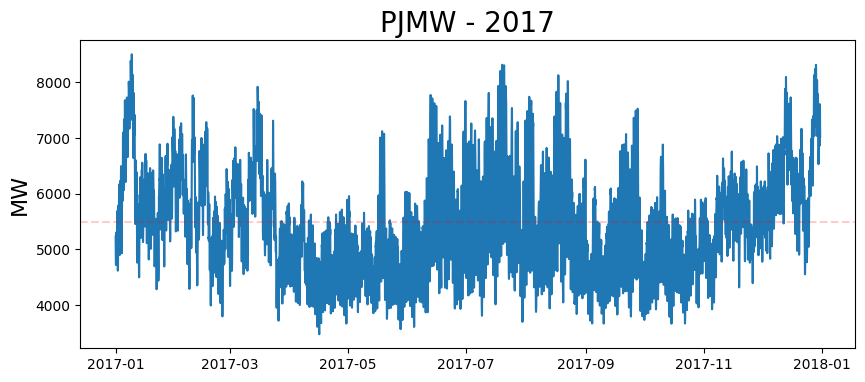

In [6]:
# plot a small subset of dataset
year = 2017
utility = "PJMW"

start_date = datetime(year, 1, 1)
end_date = datetime(year, 12, 31)
df_year = processed_data[utility][start_date:end_date]

plt.figure(figsize=(10,4))
plt.plot(df_year)
plt.title(utility + " - " + str(year), fontsize=20)
plt.ylabel('MW', fontsize=16)
for plot_year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(plot_year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

# plot the mean
mean = df_year[utility + "_MW"].mean()
plt.axhline(mean, color='r', alpha=0.2, linestyle='--')

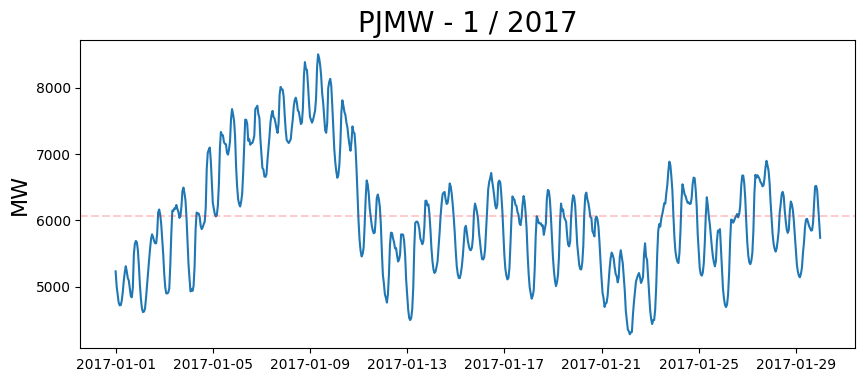

In [7]:
# zoom in on one month
month = 1

start_date = datetime(year, month, 1)
end_date = datetime(year, month, 30)
df_month = processed_data[utility][start_date:end_date]

plt.figure(figsize=(10,4))
plt.plot(df_month)
plt.title(utility + ' - ' + str(month) + ' / ' + str(year), fontsize=20)
plt.ylabel('MW', fontsize=16)
for plot_year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(plot_year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

# plot the mean
mean = df_month[utility + "_MW"].mean()
plt.axhline(mean, color='r', alpha=0.2, linestyle='--')

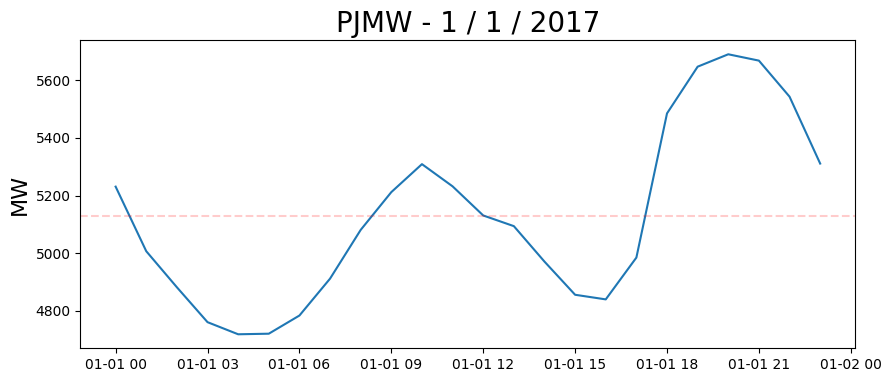

In [8]:
# zoom in on one day
day = 1

start_date = datetime(year, month, day, 0, 0)
end_date = datetime(year, month, day, 23, 0)
df_day = processed_data[utility][start_date:end_date]

plt.figure(figsize=(10,4))
plt.plot(df_day)
plt.title(utility + ' - ' + str(month) + ' / ' + str(day) + ' / ' + str(year), fontsize=20)
plt.ylabel('MW', fontsize=16)
for plot_year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(plot_year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

# plot the mean
mean = df_day[utility + "_MW"].mean()
plt.axhline(mean, color='r', alpha=0.2, linestyle='--')

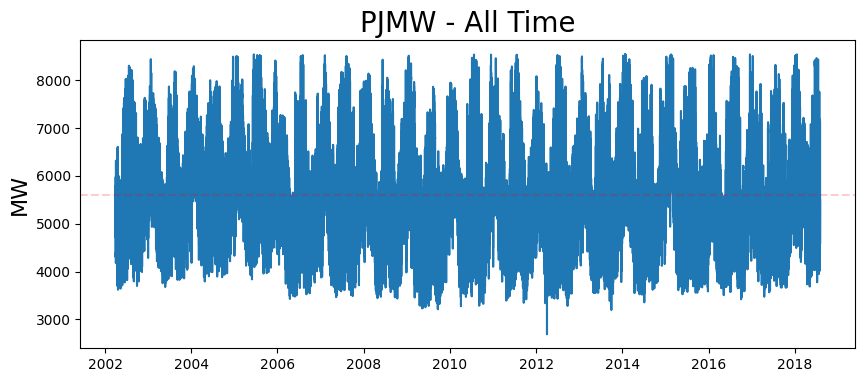

In [9]:
df_utility = processed_data[utility]

plt.figure(figsize=(10,4))
plt.plot(df_utility)
plt.title(utility + " - All Time", fontsize=20)
plt.ylabel('MW', fontsize=16)
for plot_year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(plot_year)+'-01-01'), color='k', linestyle='--', alpha=0.2, ymin=5000, ymax=25000)

# plot the mean
mean = df_utility[utility + "_MW"].mean()
plt.axhline(mean, color='r', alpha=0.2, linestyle='--')

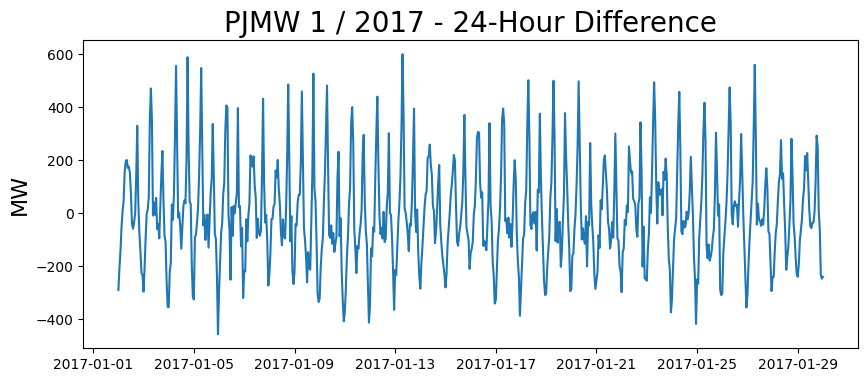

In [10]:
# daily difference

daily_diff = df_month.diff()[24:]

plt.figure(figsize=(10,4))
plt.plot(daily_diff)
plt.title(utility + ' ' + str(month) + ' / ' + str(year) + ' - 24-Hour Difference', fontsize=20)
plt.ylabel('MW', fontsize=16)
for plot_year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(plot_year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
    

<BarContainer object of 29 artists>

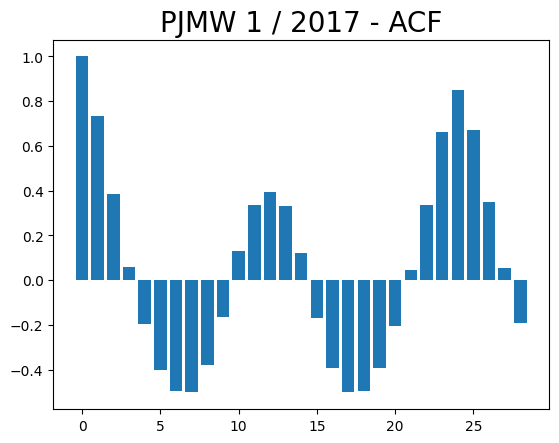

In [11]:
# Auto Correlation Function (ACF)

acf_vals = acf(daily_diff)
num_lags = 29
plt.title(utility + ' ' + str(month) + ' / ' + str(year) + ' - ACF', fontsize=20)
plt.bar(range(num_lags), acf_vals[:num_lags])

<BarContainer object of 29 artists>

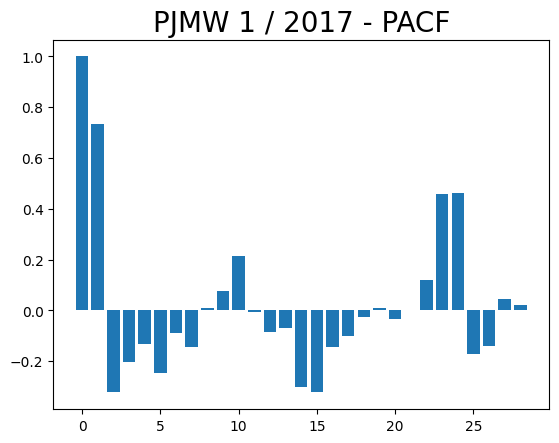

In [12]:
# Partial Auto Correlation Function

pacf_vals = pacf(daily_diff)
num_lags = 29
plt.title(utility + ' ' + str(month) + ' / ' + str(year) + ' - PACF', fontsize=20)
plt.bar(range(num_lags), pacf_vals[:num_lags])

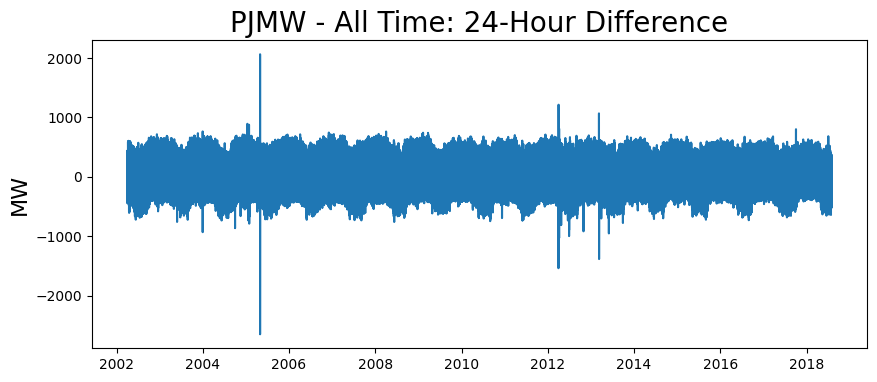

In [13]:
# daily difference - all time

daily_diff = df.diff()[24:]

plt.figure(figsize=(10,4))
plt.plot(daily_diff)
plt.title(utility + " - All Time: 24-Hour Difference", fontsize=20)
plt.ylabel('MW', fontsize=16)
for plot_year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(plot_year)+'-01-01'), color='k', linestyle='--', alpha=0.2)


##############################################################################################

### Get Training Data

In [14]:
# Train-test split: seems to be good for short-term only

df = df_month.copy(deep=True) 
mw_col = utility + "_MW"
df = df.asfreq(pd.infer_freq(df.index))

# Train-test split: 80% for training, 20% for testing
train_size = int(0.8 * len(df))
train_data = df[mw_col][:train_size]
test_data = df[mw_col][train_size:]

### Fit SARIMA model

In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import time

In [16]:
# anything higher than 1 seems to take a really long time or threaten to burn the CPU... why??
# need better understanding of each of the model parameters

my_order = (0, 0, 0)  # AR / I / MA
my_seasonal_order = (1, 0, 1, 24)  # AR / I / MA / S

# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

In [17]:
# fit the model

start = time.time()
model_fit = model.fit()
end = time.time()

print('Model Fitting Time:', str(round(end - start, 2)) + " second(s)")

Model Fitting Time: 0.53 second(s)


In [18]:
# summary of the model

# Pay close attention to P>|z| column in the summary table
# Desirable to achieve P lower than 0.05
print(model_fit.summary())

                                 SARIMAX Results                                  
Dep. Variable:                    PJMW_MW   No. Observations:                  557
Model:             SARIMAX(1, 0, [1], 24)   Log Likelihood               -4361.174
Date:                    Wed, 04 Dec 2024   AIC                           8728.348
Time:                            22:32:09   BIC                           8741.316
Sample:                        01-01-2017   HQIC                          8733.413
                             - 01-24-2017                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L24       0.9930      0.005    214.609      0.000       0.984       1.002
ma.S.L24       0.2418      0.053      4.559      0.000       0.138       0.346
sigma2      3.014e+0

In [19]:
# get the predictions and residuals

predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data - predictions

Text(0, 0.5, 'Error')

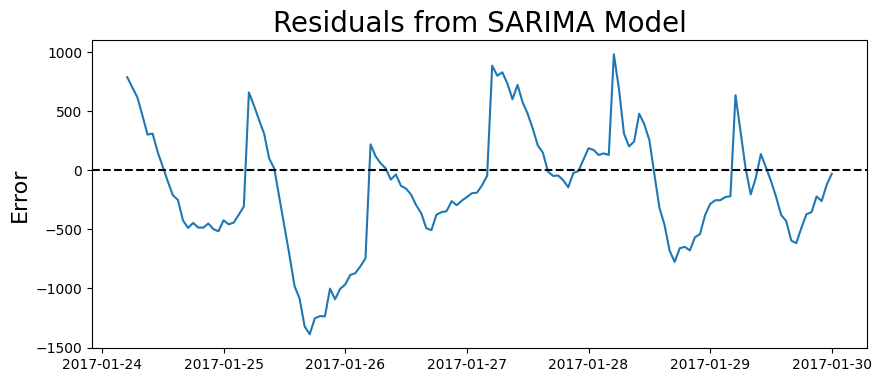

In [20]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

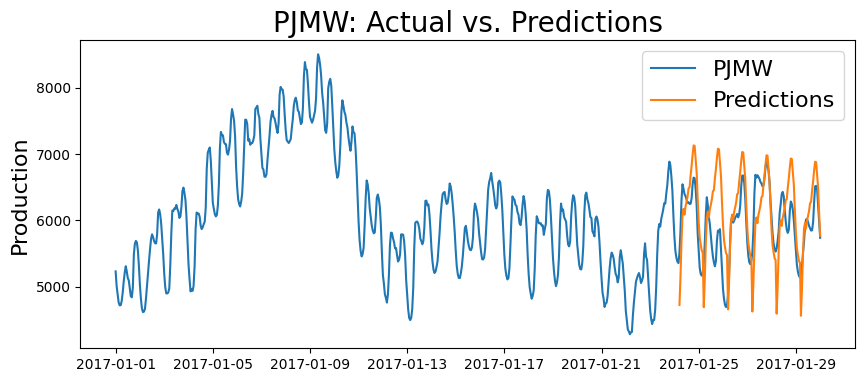

In [21]:
plt.figure(figsize=(10,4))

plt.plot(df)
plt.plot(predictions)

plt.legend((utility, 'Predictions'), fontsize=16)

plt.title(utility + ': Actual vs. Predictions', fontsize=20)
plt.ylabel('Production', fontsize=16)
for plot_year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(plot_year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [22]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 0.0717


In [24]:
print('Root Mean Squared Error:', round(np.sqrt(np.mean(residuals**2)), 4))

Root Mean Squared Error: 521.2374


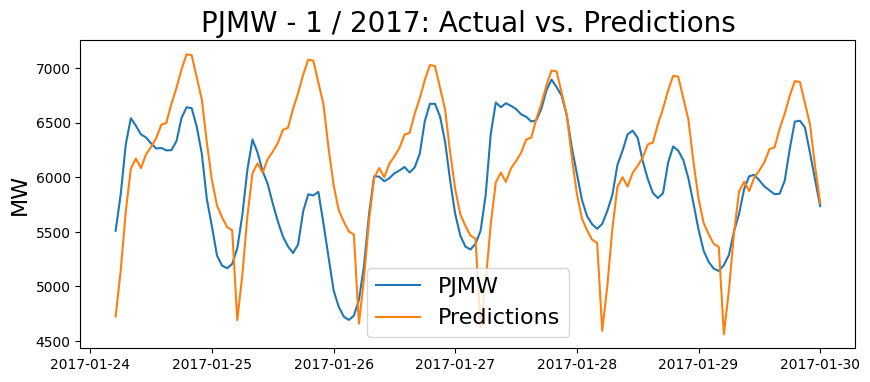

In [25]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)

plt.legend((utility, 'Predictions'), fontsize=16)

plt.title(utility + ' - ' + str(month) + ' / ' + str(year) + ": Actual vs. Predictions", fontsize=20)
plt.ylabel('MW', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

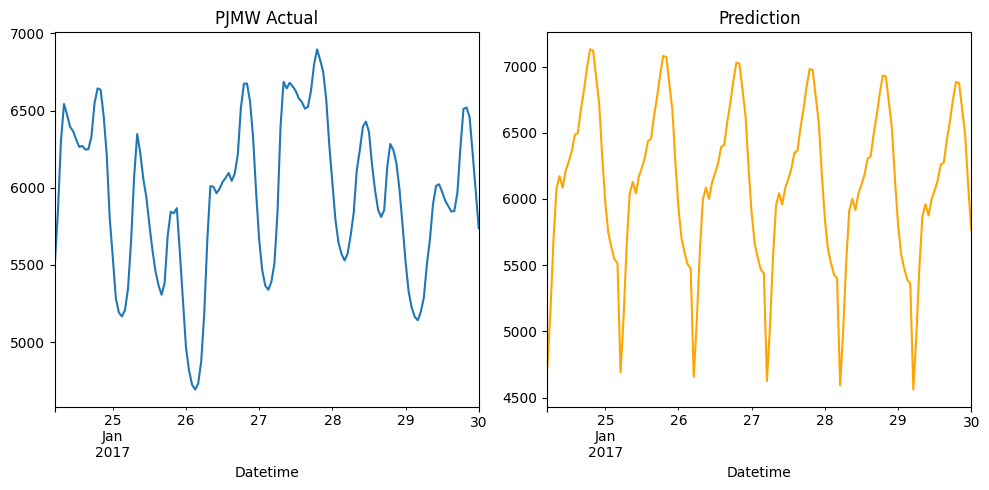

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

#test_data.plot(y='PJMW_MW', ax=axs[0], label='PJM')
test_data.plot(ax=axs[0], label=utility)
axs[0].set_title(utility + " Actual")

#predictions.plot(y='PJMW_MW', ax=axs[1], label='Prediction', color="orange")
predictions.plot(ax=axs[1], label='Prediction', color="orange")
axs[1].set_title('Prediction')

plt.tight_layout()
plt.show()


- At this point, the model exhibits some potential, but it is not quite there yet.
- Moreover, this SARIMA model with my parameters only have a very short-term predictive power. (For any time period beyond a week, it becomes rather useless.)
- Need to work on understanding the parameters better, and test out different combinations of parameters.